<center> <h1>mIA-X 8ª Edición</h1> </center>

<center> <h1>Práctica 9 - Modelos Generativos</h1> </center>

<center> <h1>Javier Langeber Gavilán</h1> </center>

<center> <h1>Ejercicio 1</h1> </center>

---

## Implementa un modelo generativo de FashionMNIST basado en PCA y GMM. Evalúa y comenta los autovectores, visualizandolos de manera apropiada.

### 1. Carga de librerías

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from tqdm import trange
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

### 2. Obtención y preparación de datos

Obtengo los datos de train y test del dataset fashion mnist

In [96]:
(x_train_pre, y_train), (x_test_pre, y_test) = fashion_mnist.load_data()

Compruebo su dimensionalidad

In [97]:
x_train_pre.shape

(60000, 28, 28)

Muestro un ejemplo de los datos

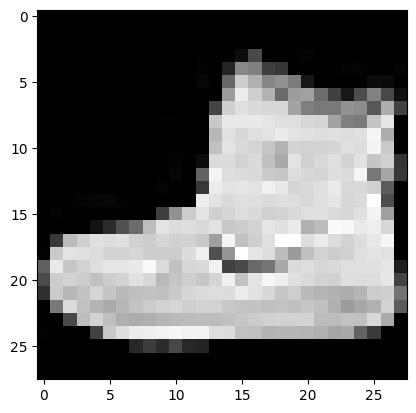

In [98]:
plt.set_cmap("gray")
plt.imshow(x_train_pre[0])

Realizo una normalización de los datos, y compruebo que está bien hecha.

In [99]:
x_train = (x_train_pre/255. - 0.5) * 2.
x_test = (x_test_pre/255. - 0.5) * 2.
print(f' Máximo valor -> {x_train.max()}')
print(f' Mínimo valor -> {x_train.min()}')

 Máximo valor -> 1.0
 Mínimo valor -> -1.0


Creo un DF con tantas columnas como imagenes tiene el dataset, con los valores de las imágenes "flatteneadas"

In [100]:
x_train_array = [x.flatten() for x in x_train]
train_df = pd.DataFrame(x_train_array)

In [101]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-0.992157,-1.0,-1.0,-1.000000,-1.000000,...,-0.066667,-0.105882,0.019608,-0.403922,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-0.827451,...,-1.000000,-1.000000,-0.992157,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.741176,-0.247059,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## 3. Estudio de reducción de la dimensionalidad

A continuación, antes de realizar un modelo generativo basado en PCA y GMM, se va a realizar un estudio de la reducción de la dimensionaldiad

### 3.1. PCA Multidimensional

Realizo la PCA del DF anterior

In [102]:
pca_dim = min(train_df.shape[0], train_df.shape[1])
pca = PCA(n_components=pca_dim)
components = pca.fit_transform(X=train_df)

Miro la varianza explicada por cada una de las componentes principales, así como la suma acumulada de la varianza explicada

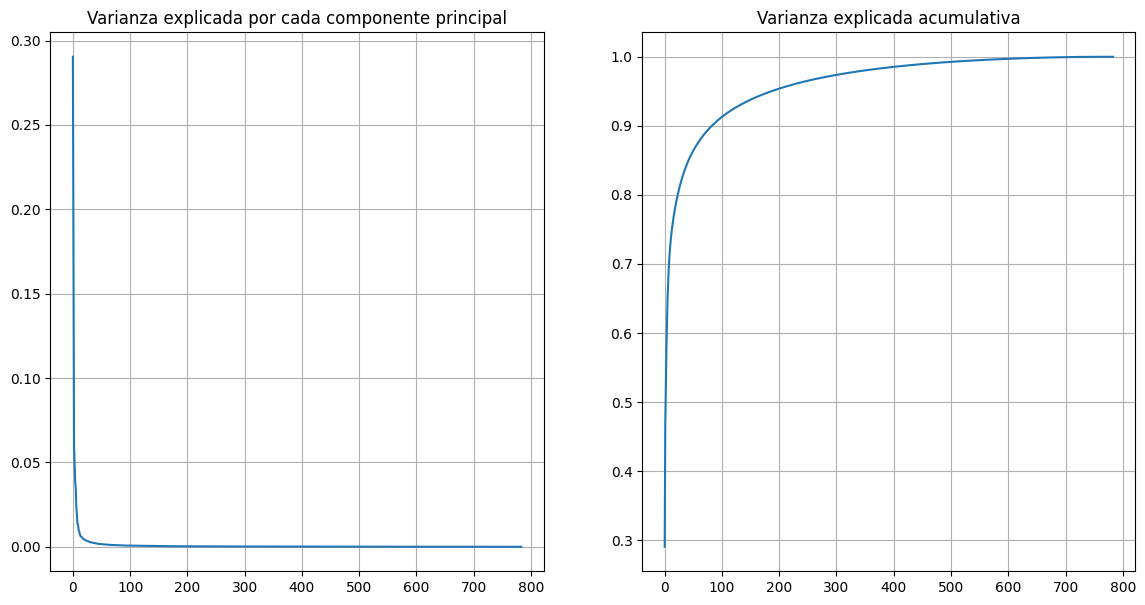

In [103]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
ax1.plot(pca.explained_variance_ratio_)
ax1.grid()
ax1.title.set_text('Varianza explicada por cada componente principal')
ax2.plot(pca.explained_variance_ratio_.cumsum())
ax2.grid()
ax2.title.set_text('Varianza explicada acumulativa')

Se muestra también el corte que se hace, para obtener una varianza explicada del 90%

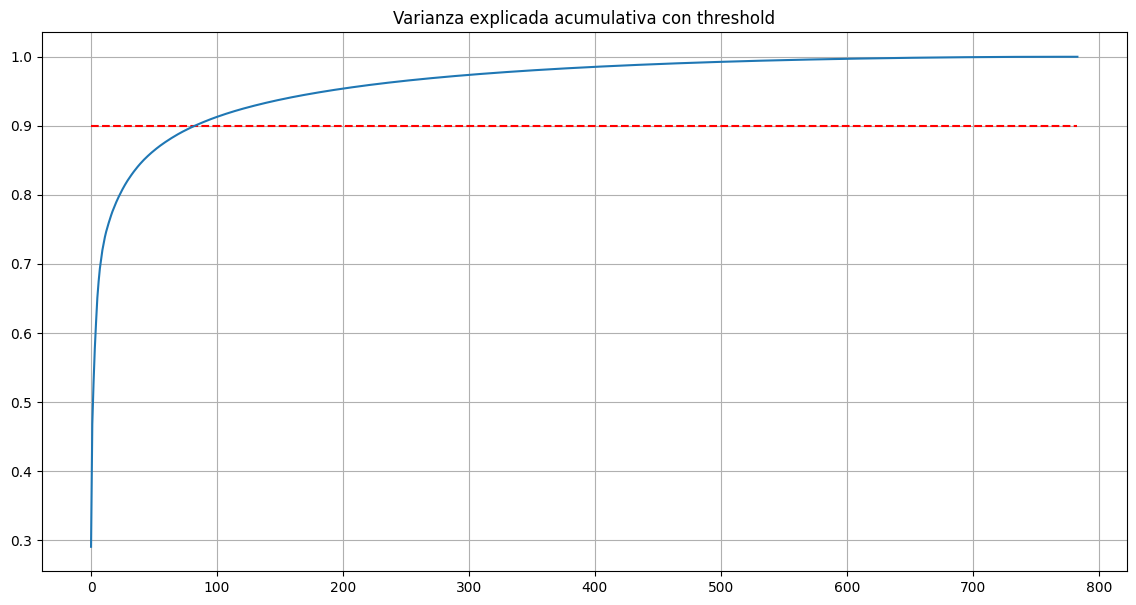

In [104]:
# Aplicamos threshold de 90%
fig, ax1 = plt.subplots(figsize = (14,7))
ax1.plot(np.ones(pca_dim)*0.9, "--", c="r")
ax1.plot(pca.explained_variance_ratio_.cumsum())
ax1.grid()
ax1.title.set_text('Varianza explicada acumulativa con threshold')

Por curiosidad, se muestra como se va explicando la varianza de los datos con los 5 primeros componentes principales

In [105]:
cumvar_5first = [pca.explained_variance_ratio_.cumsum()[_] for _ in range(0,5)]
pd.DataFrame(cumvar_5first, columns = ['Cumulative Explained Variance'])

,Cumulative Explained Variance
0,0.290392
1,0.467945
2,0.528138
3,0.577712
4,0.616188


Y se obtiene el número de componentes principales para obtener una varianza explicada acumulada de más del 90%

In [106]:
np.argmax(pca.explained_variance_ratio_.cumsum() > 0.9)

83

Además, se puede obtener el vector de cada una de las componentes principales (no se pude plotear por ser multidimensional).

In [107]:
pca.components_

array([[ 1.76521515e-07,  2.44768364e-06,  1.67354171e-05, ...,
         1.06623293e-03,  1.14054578e-04,  1.30759064e-05],
       [-2.00777633e-07,  3.25916172e-06,  7.20161624e-06, ...,
         2.38633309e-03,  7.40179648e-04,  6.89874688e-05],
       [ 5.67039716e-07, -5.64584997e-07,  1.13361831e-05, ...,
        -5.54570529e-04, -9.14299655e-04, -7.12402066e-05],
       ...,
       [-5.31485046e-02,  9.15636773e-02, -2.52353352e-02, ...,
         5.77848186e-04,  6.48492102e-05, -2.10358005e-04],
       [ 2.14177231e-01,  9.52269339e-01, -1.94185217e-01, ...,
         2.10172378e-04,  9.25080086e-05,  6.16019801e-04],
       [ 9.75083296e-01, -2.07761186e-01,  2.44666941e-02, ...,
        -8.45927231e-05,  1.48207026e-04, -1.68034102e-03]])

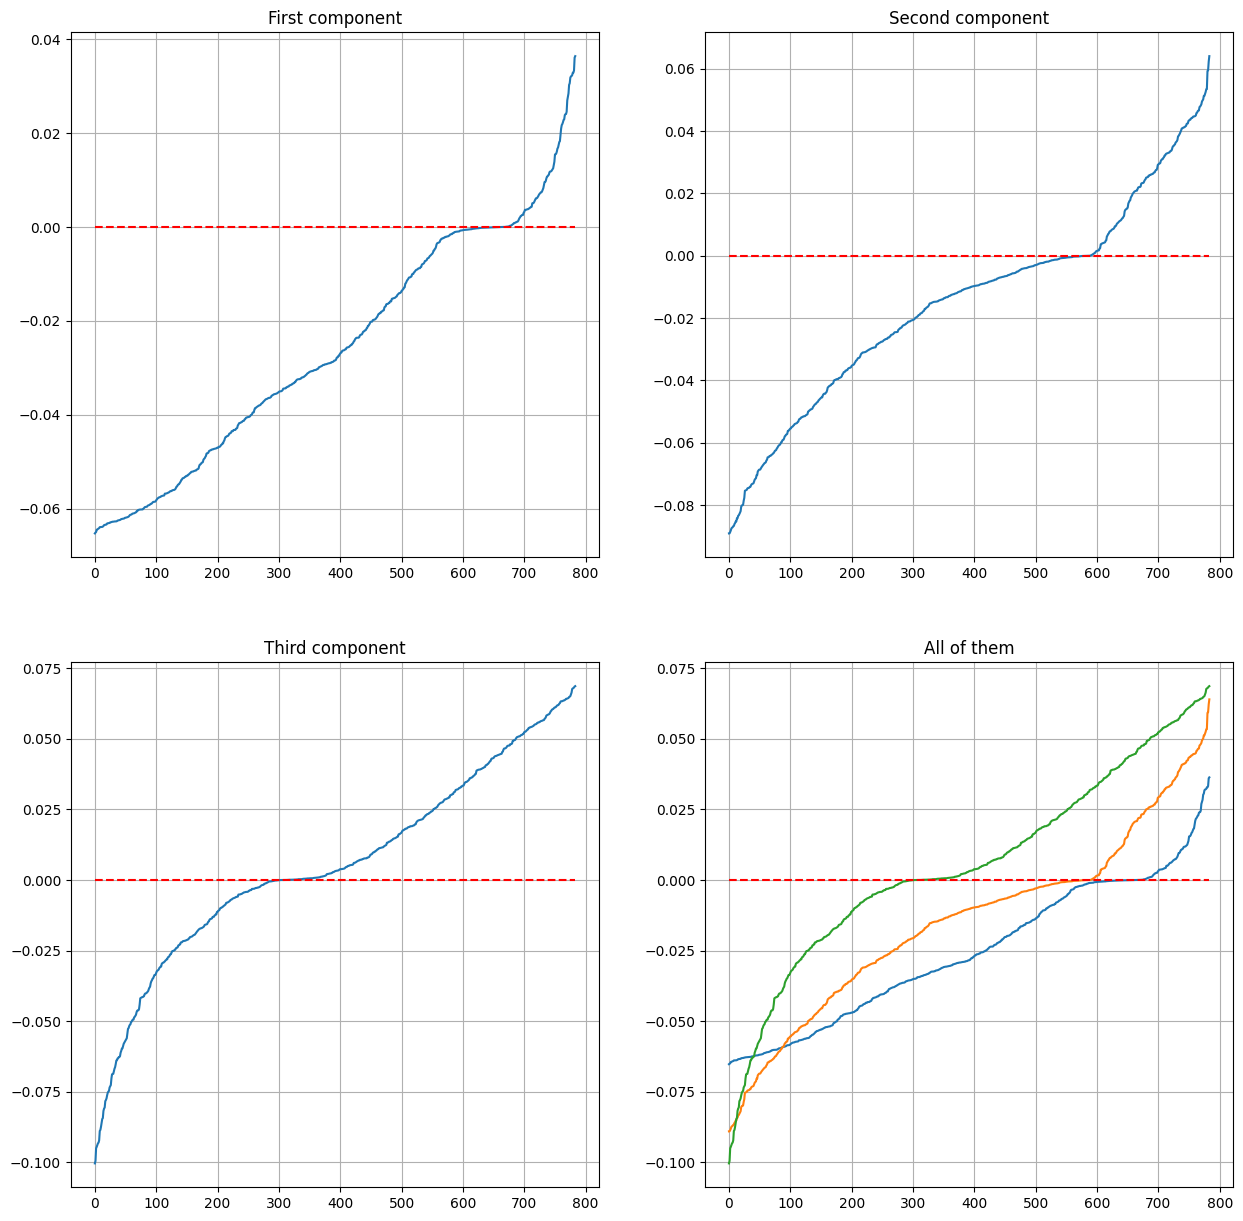

In [108]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,15))

ax1.plot(np.sort(-pca.components_[0]))
ax1.plot(np.zeros(train_df.shape[1]), "--", c="r")
ax1.grid()
ax1.title.set_text('First component')

ax2.plot(np.sort(-pca.components_[1]))
ax2.plot(np.zeros(train_df.shape[1]), "--", c="r")
ax2.grid()
ax2.title.set_text('Second component')

ax3.plot(np.sort(-pca.components_[2]))
ax3.plot(np.zeros(train_df.shape[1]), "--", c="r")
ax3.grid()
ax3.title.set_text('Third component')

ax4.plot(np.sort(-pca.components_[0]))
ax4.plot(np.sort(-pca.components_[1]))
ax4.plot(np.sort(-pca.components_[2]))
ax4.plot(np.zeros(train_df.shape[1]), "--", c="r")
ax4.grid()
ax4.title.set_text('All of them')

### 3.2. PCA Bidimensional

Ahora se realiza una PCA con únicamente 2 componentes principales

In [109]:
pca2d = PCA(n_components=2)
components2d = pca2d.fit_transform(train_df)

Se muestra la varianza explicada (tanto individual como acumulativa), y el mapa de componentes principales

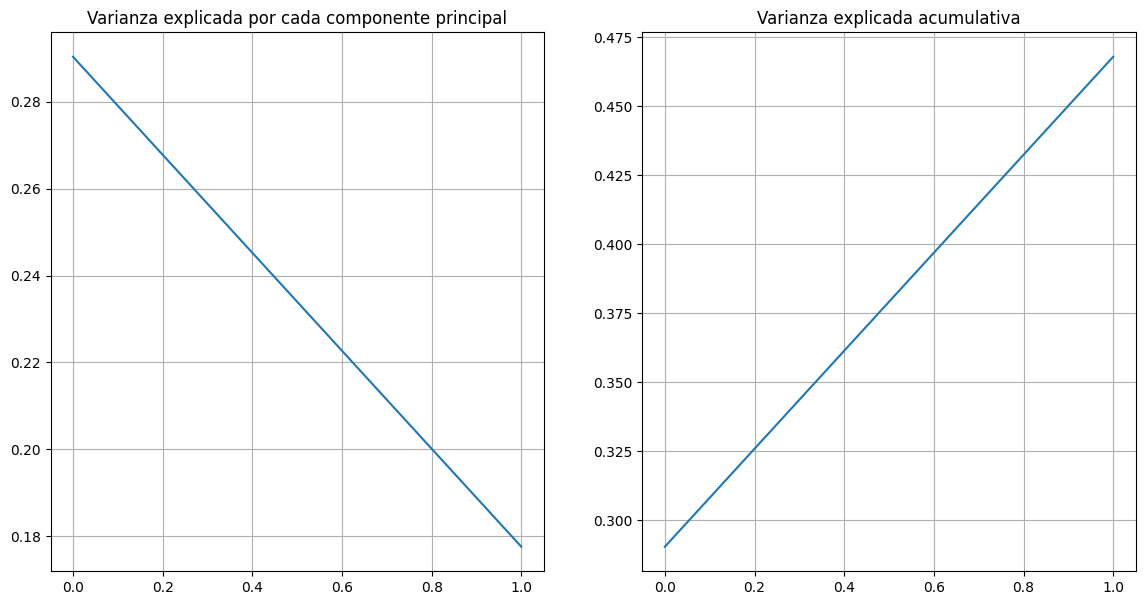

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
ax1.plot(pca2d.explained_variance_ratio_)
ax1.grid()
ax1.title.set_text('Varianza explicada por cada componente principal')
ax2.plot(pca2d.explained_variance_ratio_.cumsum())
ax2.grid()
ax2.title.set_text('Varianza explicada acumulativa')

Se muestra el diagrama de dispersión de las 2 componentes principales

Text(0.5, 1.0, 'Componentes pricipales según PCA con 2 componentes')

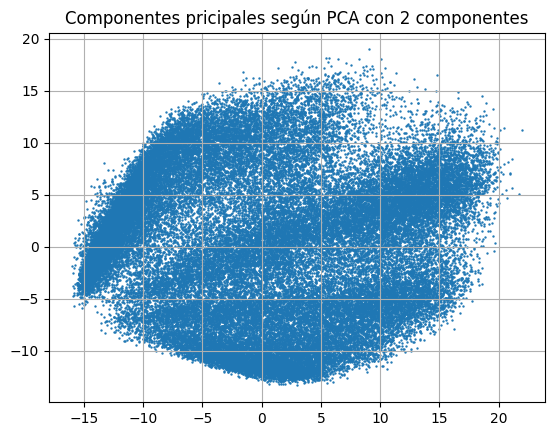

In [125]:
plt.scatter(components2d[:, 0], components2d[:, 1], s=0.5)
plt.grid()
plt.title('Componentes pricipales según PCA con 2 componentes')

### 3.3. GMM

Por último, se estudia la reducción de dimensionalidad mediante GMM, con 2 componentes.

In [112]:
gmm2 = GaussianMixture(n_components=2, covariance_type="diag")
gmm2.fit(components2d)

GaussianMixture(covariance_type='diag', n_components=2)

Muestro las componentes en un diagrama de dispersión. Facilito la visualización generando una malla.

Text(0.5, 1.0, 'Componentes pricipales según GMM con 2 componentes')

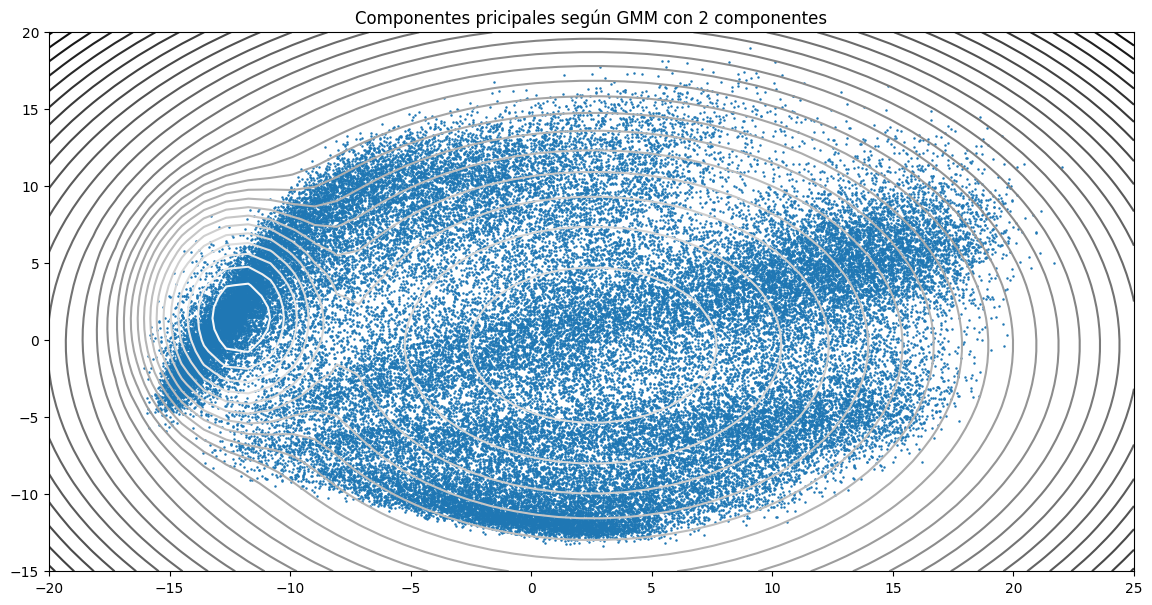

In [126]:
# Hago un grid y me ploteo el contour
xs = np.linspace(-20, 25)
ys = np.linspace(-15, 20)

Xp, Yp = np.meshgrid(xs, ys)
Xf = Xp.flatten()
Yf = Yp.flatten()
points = np.vstack([Xf, Yf])
Z = gmm2.score_samples(points.T)

plt.figure(figsize=(14,7))
plt.scatter(components2d[:,0], components2d[:, 1], s=0.6)
plt.contour(Xp, Yp, Z.reshape(50,50), 30)

plt.title('Componentes pricipales según GMM con 2 componentes')

Por úlitmo, puedo realizar una búsqueda iterativa para ver qué configuración del GMM es mejor. Para ello, creo una función que genere modelos de GMM.

In [114]:
def gridsearchgmm(data, opt_ncomponents, opt_covariance):
    results = []
    for ncomponents in opt_ncomponents:
        for covariance in opt_covariance:
            gmm_trial = GaussianMixture(n_components=ncomponents, covariance_type=covariance)
            gmm_trial.fit(data)
            bic = gmm_trial.bic(data)
            print("ncomponents {}, covariance {}, bic is {}".format(ncomponents, covariance, bic))
            results.append(bic)
    return results

Ejecuto la función para los diferentes tipos de convarianza, obteniendo los siguientes resultados.

In [117]:
opt_ncomponents = np.arange(1,5)
opt_covariance = ["diag", "full", "spherical", "tied"]
results = gridsearchgmm(components2d, opt_ncomponents, opt_covariance)

ncomponents 1, covariance diag, bic is 835766.0471416664
ncomponents 1, covariance spherical, bic is 839349.4278568901
ncomponents 1, covariance full, bic is 835777.0492415077
ncomponents 2, covariance diag, bic is 818953.904709929
ncomponents 2, covariance spherical, bic is 821701.4374038152
ncomponents 2, covariance full, bic is 805674.176856758
ncomponents 3, covariance diag, bic is 806595.3285721008
ncomponents 3, covariance spherical, bic is 816147.8448664298
ncomponents 3, covariance full, bic is 795339.6264317129
ncomponents 4, covariance diag, bic is 800131.9271327384
ncomponents 4, covariance spherical, bic is 805993.5419662523
ncomponents 4, covariance full, bic is 788511.8982687149


Text(0.5, 1.0, 'Resultados según GMM, con las diferentes configuraciones')

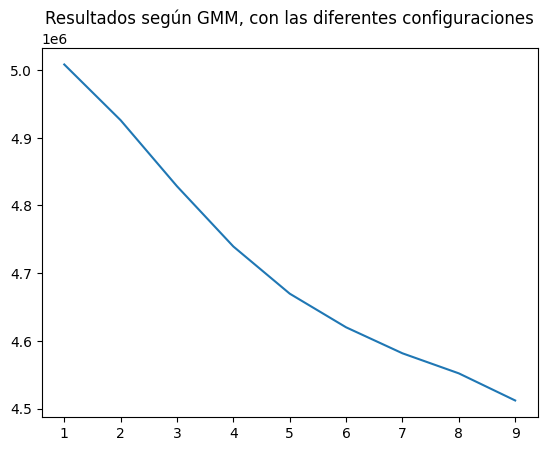

In [127]:
plt.plot(np.arange(1,10),results)
plt.title('Resultados según GMM, con las diferentes configuraciones')

## 4. Modelo generativo basado en PCA y GMM

Por último, se desarrolla un modelo generativo basado en PCA y GMM, para crear nuevas muestras del dataset Fashion Mnist

1. Se vuelven a cargar y tratar los datos

In [128]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

2. Se realiza una PCA sobre los datos

In [163]:
pca = PCA(n_components=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

3. Se ajusta un modelo GMM a los datos reducidos

In [164]:
gmm = GaussianMixture(n_components=10)
gmm.fit(x_train_pca)

GaussianMixture(n_components=10)

4. Se generan muestras del dataset Fashion Mnist utilizando el modelo GMM anterior

In [165]:
samples = gmm.sample(100)

5. Se reconstruyen las imágenes generadas y se muestran (en este caso, se muestran únicamente 6)

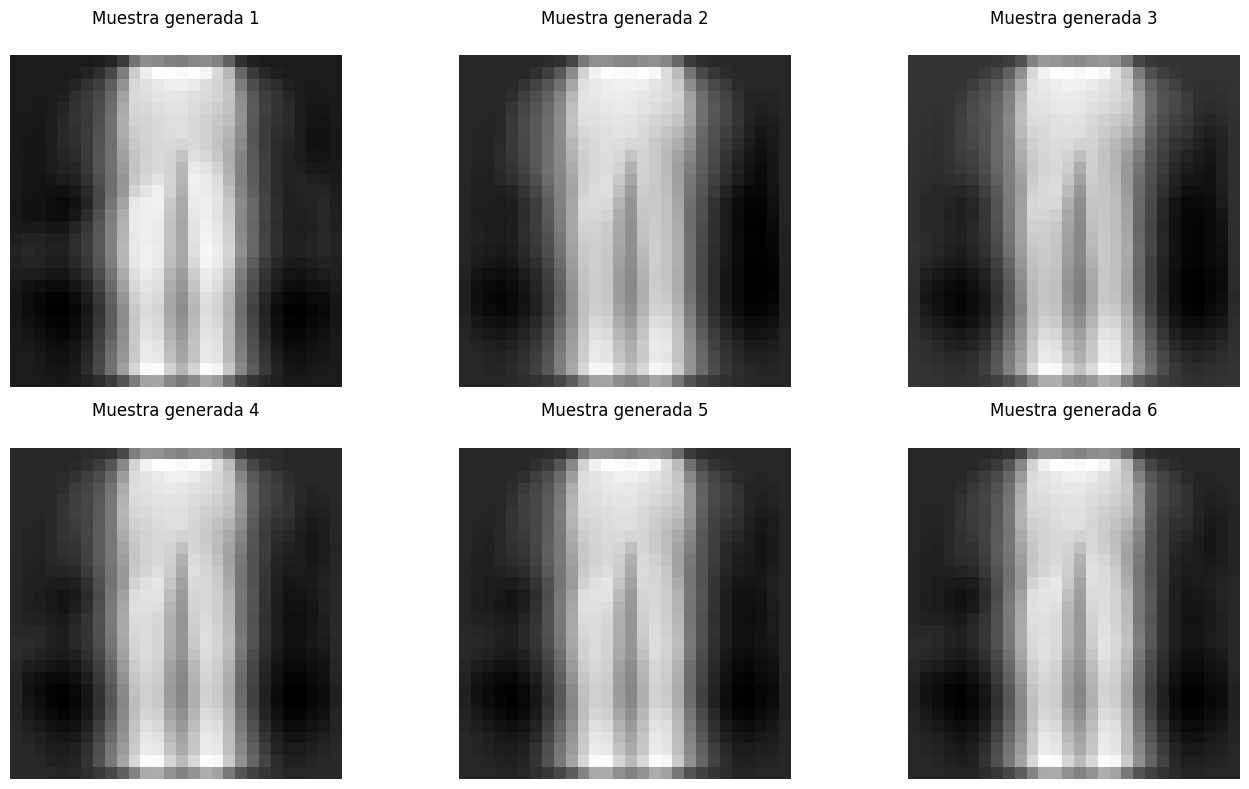

In [166]:
x_train_reconstructed = pca.inverse_transform(x_train_pca)
samples_reconstructed = pca.inverse_transform(samples[0])
samples_reconstructed = samples_reconstructed.reshape(100, 28, 28)
gen_imgs = samples_reconstructed[0:6]
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(16,8), facecolor='white')
k = 0
for i in range(0,2):
    for j in range(0,3):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[i,j].axis('off')
        axs[i,j].set_title(f'Muestra generada {k+1}')
        k += 1

Como se observa, la calidad de las muestras generadas esmuy pobre. Con la dosis sufiiente de imaginación, uno podría llegar a imaginarse unos pantalones o unas sudaderas. Modificar el número de comonentes principales del PCA, y los métodos de correlación de GMM podría ayudar a generar muestras de mayor calidad.